In [92]:
%matplotlib inline
%load_ext autoreload
%autoreload

from quanty.model import backtester as q
from quanty.model import db_manager as dm
from quanty.model import plotter as pltr
from quanty.model import setting
from quanty.model.portfolio import Port
from quanty.model.dual_momentum import DualMomentumSelector, DualMomentumPort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
db = dm.read_db(base='prices_global.pkl', add='prices_kr.pkl')

In [3]:
base_params = {
    'start': '2002-12-31', 
    'end': '2018-03-31', 
    'db': db, 
    'assets': setting.assets_global_eq, 
    'price': {'price_src':'reprice', 'trade_tol':'at_close'}, 
    'trade': {
        'trade_assets': [
            #('BND_US_Long', {'BND_US_Interm':0.3, 'BND_US_Short':0.2}), 
            #('BND_US_Long', {'BND_US_Long':1.0}), 
        ], 
        'trade_prev_nav_based': True, 
        'trade_delay': 1, 
        'cash': 100000000, 
        'expense': 0.001, 
        'gr_exposure': 0.99, }, 
    'selecting': {
        'mode': 'DualMomentum', #'DualMomentum', 'AbsoluteMomentum', 'RelativeMomentum'
        'sig_mixer': {
            'sig_w_base': [1,0,0,0,0,0,1,0,0,0,0,0], #[1,0,0,0,0,0,1,0,0,0.25*4,0.25*6,0.25*12]
            'sig_w_dynamic': True, 
            'sig_dyn_fwd': [20,40,60], 
            'sig_dyn_m_backs': 24, 
            'sig_dyn_n_sample': 60, 
            'sig_dyn_thres': 0.1, }, 
        'market': 'ACWI', # None도 가능
        'supporter': 'BND_US_Long', 
        'cash_equiv': 'BND_US_AGG', 
        'overwrite_to_bet': [], # base_params flattening 하므로, 반드시 list of tuple로 입력
        'follow_trend': (20,60), 
        'follow_trend_market': (20, 60), 
        'n_picks': 10, }, 
    'weighting': {
        'w_type': 'ranky2', 
        'eaa_wr': 1.0, 
        'eaa_wc': 1.0, 
        'eaa_wr_bnd': 0.5, 
        'eaa_short_period': 20, 
        'iv_period': 60, 
        'w_max': 1.0, }, 
    'stats_opts': {
        'beta_to': 'ACWI', 
        'stats_n_roll': 250, }, 
    'reinforce': {
        'follow_trend_supporter': (20, 60), 
        'support_cash': True, }, 
    'te_control': {
        'bm': None, #'ACWI', 
        'te_target': None, 
        'te_k': 0.3, 
        'te_short_period': 20, 
        'te_short_up_down_ratio_cap': True, 
        'te_short_target_cap': True, 
        'te_smoother': False, 
        'safety_buffer': 0.8, }, 
    'cash_manager': {
        'cm_method': None, #'cp', 
        'up_down_ratio_period': 20, 
        'kelly_type': 'semivariance', 
        'kelly_vol_period': 250, 
        'kelly_self_eval': True, }
}

In [93]:
#%%prun
geam = q.Backtester(base_params, w_type='inv_ranky2', start='2002-12-31')

1.8408000469207764



2.495999813079834


In [71]:
geam2 = q.Backtester1(base_params, w_type='inv_ranky2', start='2002-12-31')

1.7472000122070312



7.0980000495910645


In [94]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Saudi,0.90,3839,-0.67,11.17,-0.06,-46.95,0.00,0.00,-0.47,0.06,15.21,12.09,0.96,33.91
SouthAfrica,5.36,3813,11.64,33.98,0.34,-64.64,12.92,29.02,0.42,1.42,30.27,60.56,1.00,20.72
Egypt,0.72,3084,-2.63,29.88,-0.09,-78.05,-5.20,29.09,-0.18,0.36,57.00,52.74,0.98,25.08
Sweden,5.62,3839,11.90,30.09,0.40,-68.07,17.81,22.93,0.79,1.37,32.40,56.59,1.27,22.90
DualMomentum,10.70,3838,16.70,15.33,1.09,-21.29,16.62,14.74,1.16,0.20,7.41,63.54,1.43,95.96


In [85]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Saudi,0.90,3839,-0.67,11.17,-0.06,-46.95,0.00,0.00,-0.47,0.06,15.21,12.09,0.96,33.91
SouthAfrica,5.36,3813,11.64,33.98,0.34,-64.64,12.92,29.02,0.42,1.42,30.27,60.56,1.00,20.72
Egypt,0.72,3084,-2.63,29.88,-0.09,-78.05,-5.20,29.09,-0.18,0.36,57.00,52.74,0.98,25.08
Sweden,5.62,3839,11.90,30.09,0.40,-68.07,17.81,22.93,0.79,1.37,32.40,56.59,1.27,22.90
DualMomentum,10.70,3838,16.70,15.33,1.09,-21.29,16.62,14.74,1.16,0.20,7.41,63.54,1.43,95.96


In [95]:
geam.wealth

,trade_amount,value,trade_cashflow,cost,cash,nav
2003-01-02,0.000000e+00,9.900000e+07,0.000000e+00,0.000000,9.010000e+05,9.990100e+07
2003-01-03,0.000000e+00,1.004409e+08,0.000000e+00,0.000000,9.010000e+05,1.013419e+08
2003-01-06,0.000000e+00,1.012565e+08,0.000000e+00,0.000000,9.010000e+05,1.021575e+08
2003-01-07,0.000000e+00,9.915989e+07,0.000000e+00,0.000000,9.010000e+05,1.000609e+08
2003-01-08,0.000000e+00,9.901910e+07,0.000000e+00,0.000000,9.010000e+05,9.992010e+07
2003-01-09,0.000000e+00,1.005590e+08,0.000000e+00,0.000000,9.010000e+05,1.014600e+08
2003-01-10,0.000000e+00,1.011767e+08,0.000000e+00,0.000000,9.010000e+05,1.020777e+08
2003-01-13,0.000000e+00,1.021578e+08,0.000000e+00,0.000000,9.010000e+05,1.030588e+08
2003-01-14,0.000000e+00,1.018683e+08,0.000000e+00,0.000000,9.010000e+05,1.027693e+08
2003-01-15,0.000000e+00,1.009123e+08,0.000000e+00,0.000000,9.010000e+05,1.018133e+08


In [74]:
geam2.wealth

,trade_amount,value,trade_cashflow,cost,cash,nav
2002-12-31,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+08,1.000000e+08
2003-01-02,9.900000e+07,9.900000e+07,-9.900000e+07,99000.000000,9.010000e+05,9.990100e+07
2003-01-03,0.000000e+00,1.004409e+08,0.000000e+00,0.000000,9.010000e+05,1.013419e+08
2003-01-06,0.000000e+00,1.012565e+08,0.000000e+00,0.000000,9.010000e+05,1.021575e+08
2003-01-07,0.000000e+00,9.915989e+07,0.000000e+00,0.000000,9.010000e+05,1.000609e+08
2003-01-08,0.000000e+00,9.901910e+07,0.000000e+00,0.000000,9.010000e+05,9.992010e+07
2003-01-09,0.000000e+00,1.005590e+08,0.000000e+00,0.000000,9.010000e+05,1.014600e+08
2003-01-10,0.000000e+00,1.011767e+08,0.000000e+00,0.000000,9.010000e+05,1.020777e+08
2003-01-13,0.000000e+00,1.021578e+08,0.000000e+00,0.000000,9.010000e+05,1.030588e+08
2003-01-14,0.000000e+00,1.018683e+08,0.000000e+00,0.000000,9.010000e+05,1.027693e+08


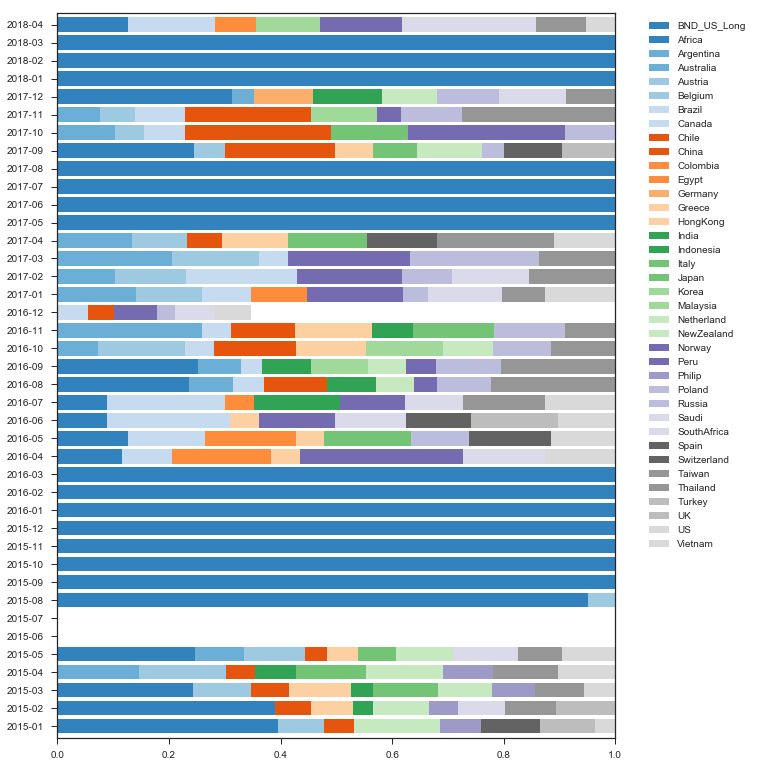

In [267]:
geam.plot_weight([2015, 2018])

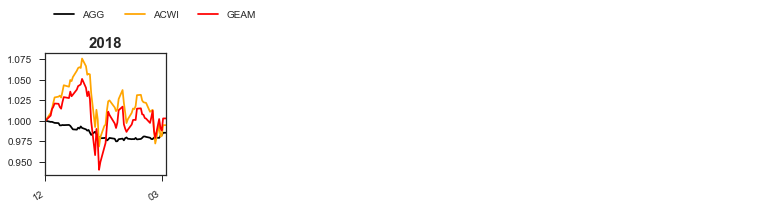

In [29]:
geam.plot_cum_yearly(strats, names=names, color=color, remove=range(2003,2018))

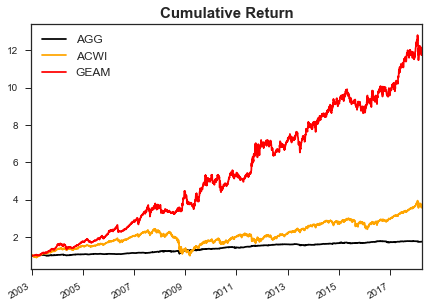

In [73]:
# 제일 수익률 좋은거: [0.25*4, 0.25*6, 0.25*12], mom_mixer에서 (drop, 수익률/변동성, thres=0.2)
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

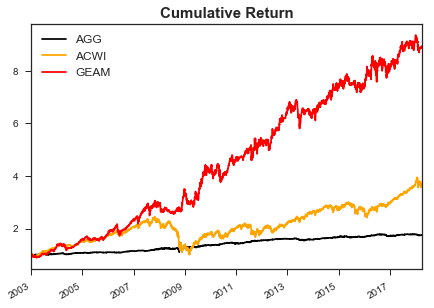

In [62]:
# 제일 맘에 드는거: 12-6개월로 하고, mom_mixer에서 (drop, 수익률 그대로, thres=0.1)
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

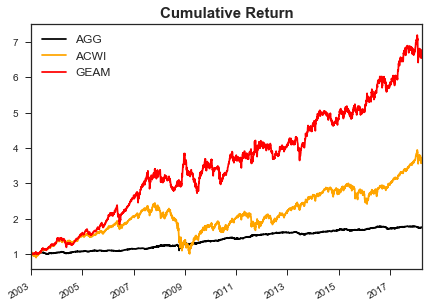

In [62]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

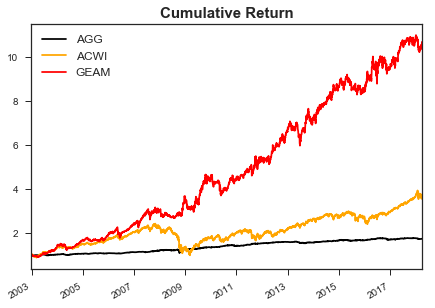

In [37]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

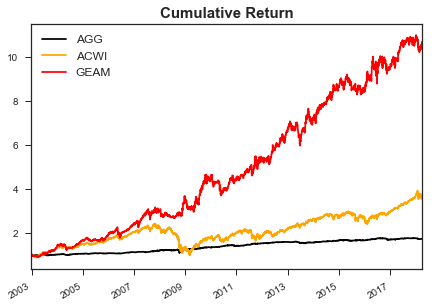

In [12]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam.plot_cum(strats, names=names, color=color, logy=False)

In [67]:
geam.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
Philip,0.41,14.28,18.67,83.40,7.76,58.79,24.79,-61.66,3839,1.22,0.57,0.89,25.09,22.43
Norway,1.33,2.25,7.16,-0.05,1.18,48.28,40.75,-50.86,1859,1.33,0.09,0.35,25.19,23.55
Saudi,0.06,-0.67,0.00,33.91,0.90,12.09,15.21,-46.95,3839,0.96,-0.06,-0.47,11.17,0.00
Korea,1.33,10.92,13.05,30.30,4.91,60.44,29.39,-74.14,3839,0.99,0.34,0.52,31.97,24.73
DualMomentum,0.20,17.58,16.86,90.60,12.01,66.48,8.41,-21.75,3839,1.24,1.15,1.19,15.33,13.84


In [105]:
geam.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
Argentina,1.05,3.42,6.38,-67.33,1.28,57.47,41.52,-51.97,1846,0.93,0.14,0.28,24.78,23.87
Philip,0.41,14.28,18.67,83.40,7.76,58.79,24.79,-61.66,3839,1.22,0.57,0.89,25.09,22.43
Africa,0.70,0.48,5.30,3.42,1.06,52.99,40.53,-63.38,2832,1.00,0.02,0.27,22.92,20.31
Switzerland,0.88,9.40,14.19,73.55,3.97,62.64,26.10,-51.62,3839,0.99,0.47,0.85,20.13,16.09
DualMomentum,0.19,15.84,15.26,96.10,9.56,63.19,5.60,-21.25,3839,1.37,1.04,1.06,15.24,14.78


In [6]:
geam.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
Argentina,1.05,3.42,6.38,-67.33,1.28,57.47,41.52,-51.97,1846,0.93,0.14,0.28,24.78,23.87
Philip,0.41,14.28,18.67,83.40,7.76,58.79,24.79,-61.66,3839,1.22,0.57,0.89,25.09,22.43
Singapore,1.03,11.57,14.69,42.91,5.37,59.89,27.19,-63.80,3839,1.11,0.46,0.82,24.98,19.89
Canada,0.96,9.06,12.63,-14.20,3.79,59.34,26.04,-60.75,3839,1.06,0.41,0.74,22.16,17.30
DualMomentum,0.19,16.22,15.55,96.10,10.05,62.64,5.54,-21.29,3839,1.44,1.06,1.08,15.24,14.69


In [16]:
geam.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
Austria,1.18,9.70,15.81,-150.41,4.14,59.89,33.73,-75.69,3839,1.00,0.35,0.73,27.53,21.08
Taiwan,1.06,8.28,10.88,57.15,3.39,54.95,28.52,-62.91,3839,1.18,0.30,0.52,27.24,22.57
Norway,1.33,2.25,7.16,-0.05,1.18,48.28,40.75,-50.86,1859,1.33,0.09,0.35,25.19,23.55
Africa,0.70,0.48,5.30,3.42,1.06,52.99,40.53,-63.38,2832,1.00,0.02,0.27,22.92,20.31
DualMomentum,0.20,16.55,16.65,96.33,10.49,63.19,7.41,-21.29,3839,1.42,1.08,1.16,15.33,14.74


In [72]:
geam2.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Saudi,0.90,3839,-0.67,11.17,-0.06,-46.95,0.00,0.00,-0.47,0.06,15.21,12.09,0.96,33.91
SouthAfrica,5.36,3813,11.64,33.98,0.34,-64.64,12.92,29.02,0.42,1.42,30.27,60.56,1.00,20.72
Egypt,0.72,3084,-2.63,29.88,-0.09,-78.05,-5.20,29.09,-0.18,0.36,57.00,52.74,0.98,25.08
Sweden,5.62,3839,11.90,30.09,0.40,-68.07,17.81,22.93,0.79,1.37,32.40,56.59,1.27,22.90
DualMomentum,10.68,3839,16.68,15.32,1.09,-21.29,16.65,14.74,1.16,0.20,7.41,63.19,1.43,96.00


In [70]:
geam.stats.tail()

,cum_last,n_samples,cagr,std,sharpe,mdd,cagr_roll_med,std_roll_med,sharpe_roll_med,beta,loss_proba,hit,profit_to_loss,consistency
Saudi,0.90,3839,-0.67,11.17,-0.06,-46.95,0.00,0.00,-0.47,0.06,15.21,12.09,0.96,33.91
SouthAfrica,5.36,3813,11.64,33.98,0.34,-64.64,12.92,29.02,0.42,1.42,30.27,60.56,1.00,20.72
Egypt,0.72,3084,-2.63,29.88,-0.09,-78.05,-5.20,29.09,-0.18,0.36,57.00,52.74,0.98,25.08
Sweden,5.62,3839,11.90,30.09,0.40,-68.07,17.81,22.93,0.79,1.37,32.40,56.59,1.27,22.90
DualMomentum,10.70,3838,16.70,15.33,1.09,-21.29,16.62,14.74,1.16,0.20,7.41,63.54,1.43,95.96


In [74]:
assets = {
    #'BND_US_AGG', #
    'BND_US_Short',
    'BND_US_Interm',
    #'BND_US_Long', #
    'BND_US_TIP',
    'BND_US_IG',
    'BND_US_HY',
    'BND_US_MBS',
    'BND_US_Muni',
    'BND_US_Bankloan',
    'BND_US_CB',
    'BND_US_HY_Muni',
    'BND_US_Pref',

    'BND_GlobalSov_loc',
    'BND_GlobalTip_loc',
    'BND_GlobalSov_loch',
    'BND_DevSov_loc',
    'BND_DevFloat_usd',
    'BND_DevIG_loc',
    'BND_DevHY_loc',
    'BND_EmSov_usd',
    'BND_EmSov_loc',
    'BND_EmHy_usd',
}

In [75]:
base_params = {
    'start': '2002-12-31', 
    'end': '2018-03-31', 
    'db': db, 
    'assets': assets,     
    'price': {'price_src':'reprice', 'trade_tol':'at_close'}, 
    'trade': {
        'trade_assets': [
            #('BND_US_Long', {'BND_US_AGG':0.1, 'BND_US_Interm':0.3}), 
            #('ACWI', {'Global':0.3}), 
        ], 
        'trade_prev_nav_based': True, 
        'trade_delay': 1, 
        'cash': 100000000, 
        'expense': 0.001, 
        'gr_exposure': 0.99, }, 
    'selecting': {
        'mode': 'DualMomentum', #'DualMomentum', 'AbsoluteMomentum', 'RelativeMomentum'
        'sig_mixer': {
            'sig_w_base': [1,0,0,0,0,0,1,0,0,1,2,3], 
            'sig_w_dynamic': False, 
            'sig_dyn_fwd': [20,40,60], 
            'sig_dyn_m_backs': 24, 
            'sig_dyn_n_sample': 60, 
            'sig_dyn_thres': 0.1, 
        }, 
        'market': 'BND_US_AGG', 
        'supporter': 'BND_US_Long', 
        'cash_equiv': 'BND_US_AGG', 
        'overwrite_to_bet': [], # base_params flattening 하므로, 반드시 list of tuple로 입력
        'follow_trend': (20,60), 
        'n_picks': 5, }, 
    'weighting': {
        'w_type': 'ew', 
        'eaa_wr': 1.0, 
        'eaa_wc': 1.0, 
        'eaa_wr_bnd': 5.0, 
        'iv_period': 60, 
        'w_max': 1.0}, 
    'stats_opts': {
        'beta_to': 'ACWI', 
        'stats_n_roll': 250}, 
    'reinforce': {
        'follow_trend_supporter': (60, 250), 
        'support_cash': True}, 
    'te_control': {
        'bm': None, #'BND_US_AGG', 
        'te_target': None, #0.05, 
        'te_short_target_cap': True, 
        'te_smoother': True, 
        'safety_buffer': 0.8}, 
    'cash_manager': {
        'cm_method': None, 
        'kelly_type': 'traditional', 
        'kelly_vol_period': 60, 
        'kelly_self_eval': True}
}

In [76]:
gfam = q.Backtester(base_params, w_type='ranky2', n_picks=5)

0.5304000377655029


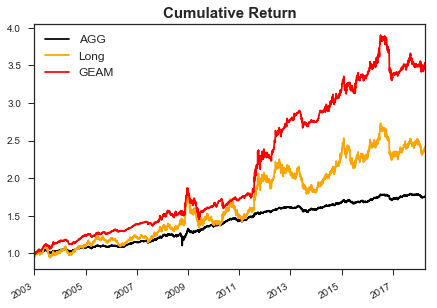

In [237]:
strats = ['BND_US_AGG', 'BND_US_Long', 'DualMomentum']
names = ['AGG', 'Long', 'GEAM']
color = ['k', 'orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

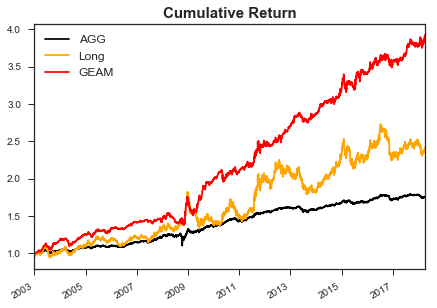

In [250]:
strats = ['BND_US_AGG', 'BND_US_Long', 'DualMomentum']
names = ['AGG', 'Long', 'GEAM']
color = ['k', 'orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

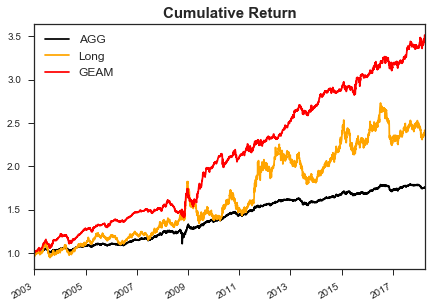

In [18]:
strats = ['BND_US_AGG', 'BND_US_Long', 'DualMomentum']
names = ['AGG', 'Long', 'GEAM']
color = ['k', 'orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

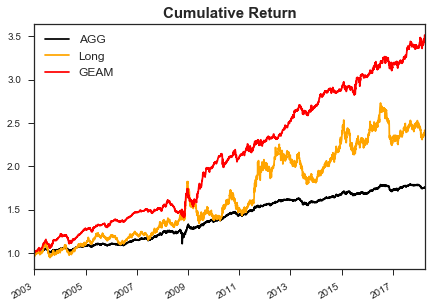

In [60]:
strats = ['BND_US_AGG', 'BND_US_Long', 'DualMomentum']
names = ['AGG', 'Long', 'GEAM']
color = ['k', 'orange', 'r']

gfam.plot_cum(strats, names=names, color=color, logy=False)

In [51]:
gfam.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
BND_DevHY_loc,0.31,7.81,7.52,-26.47,1.94,56.73,30.38,-24.07,2204,1.25,0.70,0.65,11.16,11.36
BND_US_Long,-0.28,5.91,6.49,94.38,2.41,54.95,23.12,-26.58,3839,1.24,0.44,0.56,13.53,12.78
BND_US_CB,0.44,6.88,9.53,77.79,2.77,65.75,25.81,-47.67,3829,0.91,0.63,1.03,10.89,9.15
BND_US_Pref,0.56,4.94,5.40,69.84,2.03,67.63,17.28,-65.55,3658,0.75,0.26,0.94,18.86,6.09
DualMomentum,-0.05,9.12,7.52,98.29,3.82,69.78,3.09,-14.26,3839,1.15,1.17,1.16,7.77,6.79


In [30]:
gfam.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
BND_EmSov_usd,0.14,8.15,8.46,87.65,3.33,70.33,15.77,-34.70,3839,0.88,0.86,1.46,9.43,6.80
BND_US_TIP,-0.05,4.14,3.98,88.73,1.86,64.29,23.20,-14.57,3839,0.99,0.67,0.83,6.22,5.48
Global,1.10,3.24,6.26,15.48,1.43,54.96,36.60,-61.52,2787,1.01,0.13,0.31,24.21,18.74
BND_US_HY,0.35,6.44,6.81,89.71,2.61,69.23,16.60,-34.25,3839,0.83,0.61,1.34,10.52,6.43
DualMomentum,0.00,8.53,7.10,97.77,3.51,67.03,3.90,-12.62,3839,1.34,1.26,1.25,6.76,5.64


In [77]:
gfam.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
BND_US_CB,0.44,6.88,9.53,77.79,2.77,65.75,25.81,-47.67,3829,0.91,0.63,1.03,10.89,9.15
BND_GlobalSov_loch,-0.02,3.53,3.11,92.82,1.20,68.85,6.26,-4.05,1319,1.15,1.24,1.11,2.86,3.07
BND_GlobalSov_loc,0.11,2.71,1.26,-8.48,1.33,60.80,41.45,-16.86,2647,0.85,0.31,0.16,8.86,8.01
BND_US_HY_Muni,0.01,5.56,7.80,82.94,2.30,72.53,23.20,-30.43,3839,0.73,0.85,1.81,6.52,5.89
DualMomentum,0.00,8.53,7.10,97.77,3.51,67.03,3.90,-12.62,3839,1.34,1.26,1.25,6.76,5.64


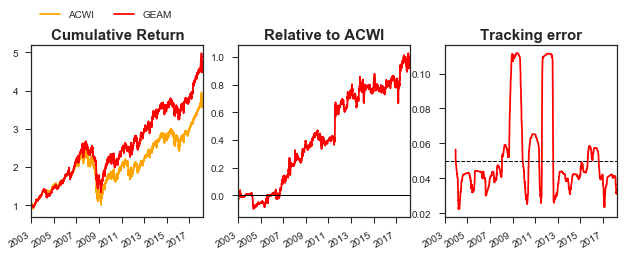

In [9]:
strats = ['ACWI', 'DualMomentum']
names = ['ACWI', 'GEAM']
color = ['orange', 'r']

geam.plot_cum_exc_te(strats, 'ACWI', 0.05, names=names, color=color, logy=False)

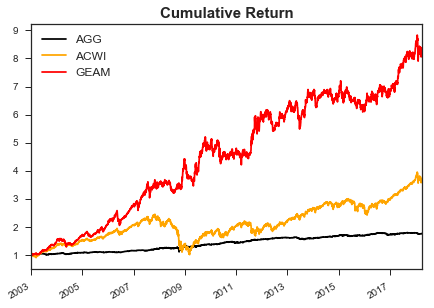

In [64]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam_inv_ranky2.plot_cum(strats, names=names, color=color, logy=False)

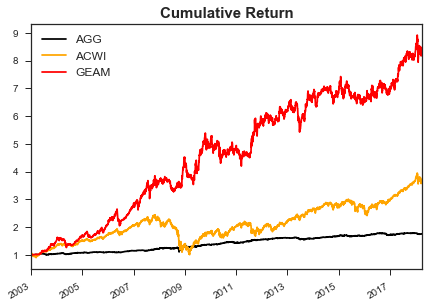

In [141]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['AGG', 'ACWI', 'GEAM']
color = ['k', 'orange', 'r']

geam_eaa_optima.plot_cum(strats, names=names, color=color, logy=False)

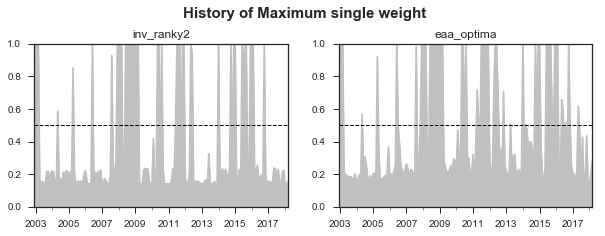

In [138]:
pltr.plot_max_single_weight(geam_inv_ranky2, geam_eaa_optima, names=['inv_ranky2', 'eaa_optima'])

In [66]:
geam_inv_ranky2.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
US,0.90,9.22,12.66,79.52,4.04,67.58,14.84,-55.19,3955,0.87,0.51,1.02,17.93,12.62
Turkey,1.35,11.53,10.64,-80.38,5.62,58.24,40.42,-76.62,3955,1.05,0.30,0.32,38.91,33.29
HongKong,1.02,11.01,15.33,72.74,5.22,63.74,20.45,-63.58,3955,0.95,0.45,0.89,24.58,18.60
NewZealand,0.25,6.20,0.00,64.01,2.59,31.32,8.82,-23.20,3955,1.06,0.51,0.81,12.09,10.95
DualMomentum,0.21,14.29,13.25,78.83,8.27,63.19,17.16,-21.75,3955,1.25,0.94,0.92,15.20,13.52


In [142]:
geam_eaa_optima.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
US,0.90,9.22,12.66,79.52,4.04,67.58,14.84,-55.19,3955,0.87,0.51,1.02,17.93,12.62
Turkey,1.35,11.53,10.64,-80.38,5.62,58.24,40.42,-76.62,3955,1.05,0.30,0.32,38.91,33.29
HongKong,1.02,11.01,15.33,72.74,5.22,63.74,20.45,-63.58,3955,0.95,0.45,0.89,24.58,18.60
NewZealand,0.25,6.20,0.00,64.01,2.59,31.32,8.82,-23.20,3955,1.06,0.51,0.81,12.09,10.95
DualMomentum,0.18,14.40,12.61,78.78,8.40,59.89,17.13,-22.67,3955,1.42,0.94,0.83,15.37,14.15


In [140]:
geam_inv_ranky2 = q.Backtester(base_params, w_type='inv_ranky2')
#geam_eaa_optima = q.Backtester(base_params, w_type='eaa_optima')

## 글로벌주식

글로벌주식 베스트
- 종목10개, ranky2, [1,0,0,0,0,0,1,0,0,1,2,3], traditional, 60, self_eval=True, riskfree=BND_US_Long, cash_equiv=BND_US_Interm, overall_market_check=True, self_trend=(20,60)

위에껀 잘 안되는거 같고
종목10개, iv(60), self_trend=(20,60), rf_trend=None, apply_kelly=None, rf=BND_US_Long, cash=BND_US_AGG 으로 일단 하자...

In [30]:
%%prun
bt_geam = Backtester(base_params)

In [25]:
bt_geam.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
Norway,1.33,2.25,7.16,-0.05,1.18,48.28,40.75,-50.86,1859,1.33,0.09,0.35,25.19,23.51
Canada,0.96,9.06,12.63,-14.20,3.79,59.34,26.04,-60.75,3839,1.06,0.41,0.74,22.16,17.26
Vietnam,0.51,-1.30,-4.75,38.64,0.86,50.00,57.48,-69.65,2841,1.10,-0.05,-0.19,26.76,27.60
Australia,1.23,10.59,15.28,26.35,4.69,60.44,28.61,-66.98,3839,1.03,0.39,0.78,27.42,19.60
DualMomentum,0.17,13.48,11.37,70.57,6.97,61.54,17.63,-21.70,3839,1.29,0.91,0.81,14.79,13.19


In [29]:
bt_geam.stats.tail()

,beta,cagr,cagr_roll_med,consistency,cum_last,hit,loss_proba,mdd,n_samples,profit_to_loss,sharpe,sharpe_roll_med,std,std_roll_med
Norway,1.33,2.25,7.16,-0.05,1.18,48.28,40.75,-50.86,1859,1.33,0.09,0.35,25.19,23.55
Canada,0.96,9.06,12.63,-14.20,3.79,59.34,26.04,-60.75,3839,1.06,0.41,0.74,22.16,17.30
Vietnam,0.51,-1.30,-4.75,38.64,0.86,50.00,57.48,-69.65,2841,1.10,-0.05,-0.19,26.76,27.66
Australia,1.23,10.59,15.28,26.35,4.69,60.44,28.61,-66.98,3839,1.03,0.39,0.77,27.42,19.64
DualMomentum,0.17,13.48,11.37,70.57,6.97,61.54,17.63,-21.70,3839,1.29,0.91,0.81,14.79,13.22


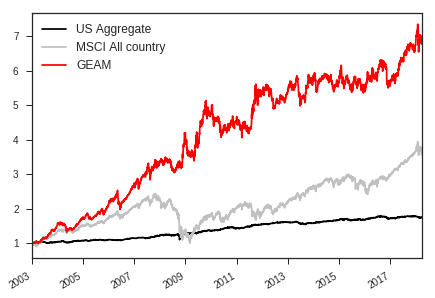

In [21]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['US Aggregate', 'MSCI All country', 'GEAM']
color = ['k', 'silver', 'r']

bt_geam.plot_cum(strats, names=names, color=color, logy=False)

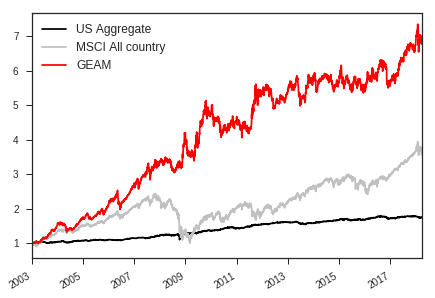

In [8]:
strats = ['BND_US_AGG', 'ACWI', 'DualMomentum']
names = ['US Aggregate', 'MSCI All country', 'GEAM']
color = ['k', 'silver', 'r']

bt_geam.plot_cum(strats, names=names, color=color, logy=False)

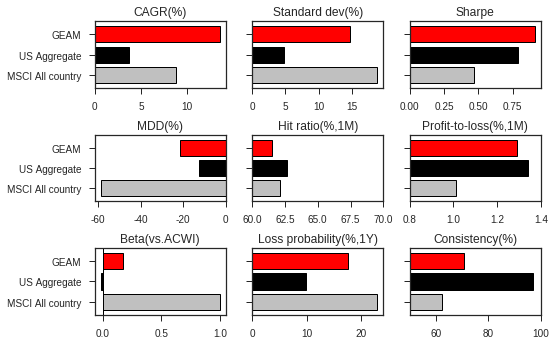

In [282]:
strats = ['ACWI', 'BND_US_AGG', 'DualMomentum']
names = ['MSCI All country', 'US Aggregate', 'GEAM']
color = ['silver', 'k', 'r']

bt_geam.plot_stats(strats, names=names, color=color, 
              lim=[None,None,None,None,(60,70),(0.8,1.4),None,None,(50,100)]
             )

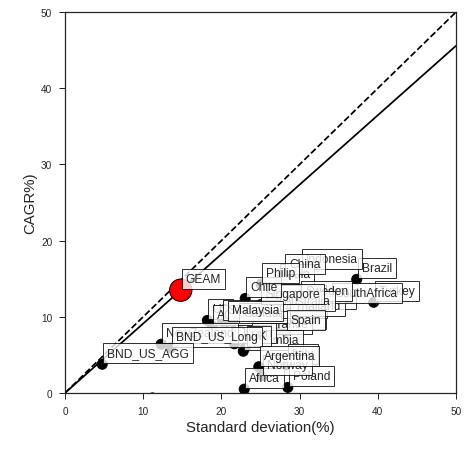

In [283]:
bt_geam.plot_profile(['DualMomentum'], names=['GEAM'], color=['r'], bsize=[500])

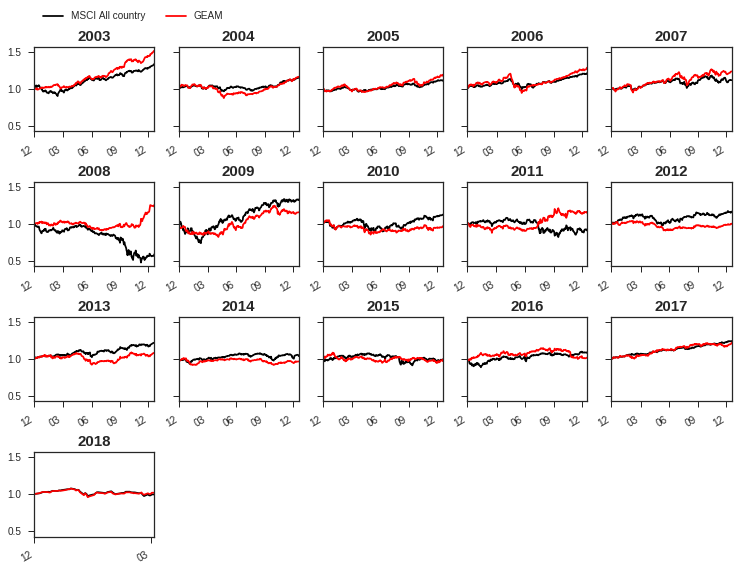

In [284]:
strats = ['ACWI', 'DualMomentum']
names = ['MSCI All country', 'GEAM']
color = ['k', 'r']

bt_geam.plot_cum_yearly(strats, names=names, color=color)

In [49]:
geam.p_close

,India,Malaysia,Sweden,NewZealand,Indonesia,US,Australia,BND_US_AGG,Philip,Russia,...,Peru,Global,BND_US_Interm,China,Greece,Japan,Italy,Netherland,Germany,France
2001-01-02,5.207148,8.689,12.629396,18.846547,2.533497,92.533,4.786009,51.266061,7.493757,NaN,...,NaN,NaN,NaN,11.531807,NaN,36.19,27.601892,16.481383,14.0750,16.8275
2001-01-03,5.244623,8.689,12.762396,18.846547,2.470670,96.978,4.878001,50.981019,7.641340,NaN,...,NaN,NaN,NaN,11.203818,NaN,37.84,27.601892,17.027825,14.3448,16.5719
2001-01-04,5.341018,8.579,12.850951,18.846547,2.511976,95.934,4.908699,51.240396,7.739168,NaN,...,NaN,NaN,NaN,11.754271,NaN,35.99,27.601892,16.891187,14.2549,16.6571
2001-01-05,5.455763,8.689,13.116839,18.846547,2.559242,92.803,4.908699,51.517793,7.693017,NaN,...,NaN,NaN,NaN,11.869347,NaN,35.78,27.601892,16.754550,14.1200,16.6571
2001-01-08,5.344214,8.799,13.028284,18.846547,2.536804,93.521,4.755311,51.599702,7.815629,NaN,...,NaN,NaN,NaN,12.183709,NaN,35.99,27.524803,16.709076,14.1200,16.4015
2001-01-09,5.359266,8.689,13.116839,18.846547,2.516247,93.274,4.786009,51.463187,7.980599,NaN,...,NaN,NaN,NaN,12.256854,NaN,35.78,27.601892,16.754550,13.9851,16.2737
2001-01-10,5.274057,8.909,12.762396,18.846547,2.527586,94.913,4.786009,51.279166,7.889166,NaN,...,NaN,NaN,NaN,12.432380,NaN,35.58,27.447714,16.435910,13.8951,16.1885
2001-01-11,5.210499,8.799,13.427060,18.846547,2.449875,95.003,4.786009,51.237666,7.803729,NaN,...,NaN,NaN,NaN,12.025422,NaN,34.55,28.064525,16.936769,14.2999,16.4441
2001-01-12,5.228077,8.799,13.471393,18.846547,2.436343,94.823,4.755311,51.003407,7.905202,NaN,...,NaN,NaN,NaN,12.317654,NaN,34.55,28.372880,16.845714,14.2999,16.7849
2001-01-16,5.261170,8.799,13.249839,18.846547,2.494679,95.429,4.755311,51.071118,7.754347,NaN,...,NaN,NaN,NaN,12.680818,NaN,35.17,27.987436,16.618021,14.2549,16.4867


In [53]:
geam.p_close[['India','US']]=np.nan

In [17]:
{'a':1, 'b':2}.values()

dict_values([1, 2])

In [34]:
geam.weight.UK[geam.weight.UK!=0]

2003-05-30    0.155392
2003-06-30    0.146505
2004-04-30    0.133522
2009-05-29    0.133522
2009-06-30    0.117755
2009-07-31    0.126877
2009-09-30    0.155392
2009-11-30    0.125885
2012-08-31    0.146505
2013-07-31    0.133522
2013-12-31    0.133522
2016-05-31    0.155392
Name: UK, dtype: float64

In [178]:
pd.DataFrame([1,2,3, np.nan]).sum(skipna=False)

0   NaN
dtype: float64

In [62]:
df = pd.DataFrame(index=[1,2,3], columns=[4,5,6])
#df['a'] = pd.Series([1,2,3], index=[1,2,3])
#df['b'] = pd.Series([1,2,3], index=[2,3,4])
df

,4,5,6
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN


In [11]:
df = pd.DataFrame([[1,2,3],[4,5,6]], columns=['a','b','c']); df

,a,b,c
0,1,2,3
1,4,5,6


In [13]:
base = [1]

In [14]:
base + [df.loc[row] for row in df.index]

[1, a    1
 b    2
 c    3
 Name: 0, dtype: int64, a    4
 b    5
 c    6
 Name: 1, dtype: int64]